In [78]:
from collections import namedtuple
import os
import random
import time

from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import scipy.stats
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, Matern
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm.notebook import tqdm

from neuralprocesses import split_context_target, NeuralProcessParams
from neuralprocesses import network
from neuralprocesses import loss
from neuralprocesses import predict
from neuralprocesses import process

tf.get_logger().setLevel('ERROR')

ccycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_samples(xs, sample_ys, xlim=(-1.0, 1.0), ax=None, c=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 6))
    if c is None:
        c = ccycle[0]
    n_samples = sample_ys.shape[1]
    for i in range(n_samples):
        ax.plot(xs, sample_ys[:,i], c=c, alpha=15.0 / n_samples)
    return ax

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


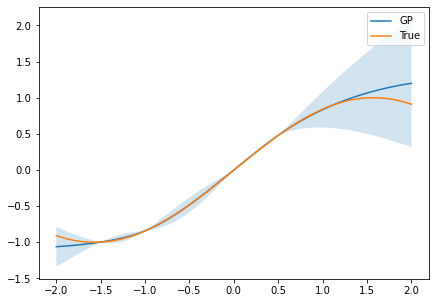

In [450]:
# playing around with the Gaussian Processes package

x_space = np.linspace(-2, 2, 100).reshape(-1, 1)

x_c = np.array([-1.5, -1, 0, 0.2, 0.5]).reshape(-1, 1)
y_c = np.sin(x_c)

kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)

gp_model = GaussianProcessRegressor(kernel=kernel, random_state=0)
gp_model.fit(x_c, y_c)

y_t, std = gp_model.predict(x_space, return_std=True)

y_t = y_t.reshape(-1)

fig, ax = plt.subplots()
ax.plot(x_space, y_t, label = "GP")
ax.fill_between(x_space.reshape(-1), y_t - 1.96*std, y_t + 1.96*std, "r", label = "_nolegend_", alpha = 0.2)
ax.plot(x_space, np.sin(x_space), label = "True")
ax.legend()

fig.set_figheight(5)
fig.set_figwidth(7)

In [495]:
#functions used below:

def draw_gp_path(x, mean_fn, kernel):
    """
    Takes as input:
    x - the points we want to evaluate
    mean_fn - the mean function of the GP
    kernel - the kernel function of the GP

    returns:
    A random gp draw evaluated at the points in x
    """
    K = kernel(x)
    mu = mean_fn(x)

    return scipy.stats.multivariate_normal.rvs(mean = mu, cov = K, size = 1)

# next two functions are for plotting
def update_k(x_new, x_c, kernel):
    """
    This function returns the posterior standard deviation of a GP

    Takes as input: 
    x_new - points we want to evaluate the new kernel at
    x_c - points we have already evaluated
    kernel - the kernel of the prior

    returns:
    The standard deviation of the posterior at the points x_new
    """
    K = kernel(x_c)
    inv_K = np.linalg.inv(K)

    n = len(x_new)

    out = np.zeros(n)

    for i in range(n):
        kx = kernel(x_c, x_new[i].reshape(-1, 1))
        out[i] = np.dot(kx.T, np.dot(inv_K, kx))
    
    k_xx = kernel.diag(x_new)

    return (k_xx - out)

def update_mean(x_new, x_c, y_c, mean_fn, kernel):
    """
    This function returns the posterior standard deviation of a GP

    Takes as input: 
    x_new - points we want to evaluate the new kernel at
    x_c - points we have already evaluated
    y_c - observed points
    mean_fn - prior mean function
    kernel - the kernel of the prior

    returns:
    The mean of the posterior at the points x_new
    """

    K = kernel(x_c.reshape(-1, 1))
    inv_K = np.linalg.inv(K)

    n = len(x_new)

    out = np.zeros(n)

    y_m = y_c - mean_fn(x_c).reshape(-1, 1)

    for i in range(n):
        kx = kernel(x_c, x_new[i].reshape(-1, 1))
        out[i] = np.dot(kx.T, np.dot(inv_K, y_m))

    return mean_fn(x_new).reshape(-1) + out.reshape(-1)


def draw_gp_post(x, x_c, mean_fn, kernel_fn):
    """
    This function returns the a sample from a posterior GP

    Takes as input: 
    x - points we want to evaluate the GP at
    x_c - points we have already evaluated
    mean_fn - mean of the POSTERIOR
    kernel_fn - kernel of the PRIOR

    returns:
    A draw from the posterior GP evaluated at x
    """
    K = kernel(x_c)
    invK = np.linalg.inv(K)
    Kx = kernel(x_c, x)
    Kxx = kernel(x)

    K = Kxx - np.dot(Kx.T, np.dot(invK, Kx))

    mu = mean_fn(x)

    return scipy.stats.multivariate_normal.rvs(mean = mu, cov = K, size = 1)

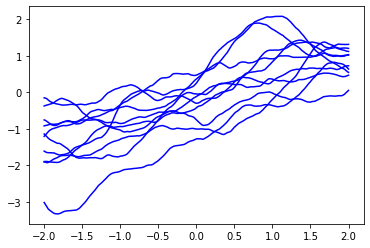

In [498]:
#example of draws from a GP
kernel = 0.5 * Matern(length_scale=1, nu=1.5)

fig, ax = plt.subplots()

func = lambda x: np.sin(x.reshape(-1))

for i in range(0, 10):
    ax.plot(x_space, draw_gp_path(x_space, func, kernel), "b")

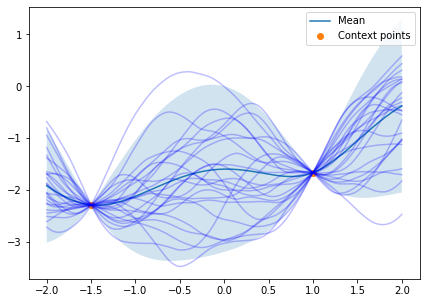

In [501]:
# example of draws from a posterior GP
kernel = 1 * Matern(length_scale=1, nu = 2.5)

x_c = np.array([-1.5, 1]).reshape(-1, 1) # choose context set

y_c = draw_gp_path(x_c, func, kernel).reshape(-1, 1) # draw y's

# plot posterior mean and bouns
x_space = np.linspace(-2, 2, 300).reshape(-1, 1)

mean = update_mean(x_space, x_c, y_c, func, kernel)
std = np.sqrt(update_k(x_space, x_c, kernel))

fig, ax = plt.subplots()
ax.plot(x_space, mean, label = "Mean")
ax.fill_between(x_space.reshape(-1), mean - 1.96*std, mean + 1.96*std, "r", label = "_nolegend_", alpha = 0.2)
ax.scatter(x_c, y_c, label = "Context points")
ax.legend()

fig.set_figheight(5)
fig.set_figwidth(7)

# define posterior mean function
func_2 = lambda x: update_mean(x, x_c, y_c, func, kernel)

# plot draws from posterior
for i in range(0, 25):
    ax.plot(x_space, draw_gp_post(x_space, x_c, func_2, kernel), "b", alpha = 0.25)

In [442]:
# this was not used, but I'm scacred to delete it
def data_generator_gp(n_iter, kernel, mean_fn):
    for i in range(n_iter):
        # Select 20 random observations from a sinoid with a random amplitude
        n_obs = 20
        xs = np.random.uniform(-2, 2, n_obs).reshape([-1, 1]).astype(np.float32)
        ys = draw_gp_path(xs, func, kernel).reshape(-1,1).astype(np.float32)

        # Random number of context points
        n_context = random.choice(range(1, 11))
        context_xs, context_ys, target_xs, target_ys = split_context_target(xs, ys, n_context)
        yield context_xs, context_ys, target_xs, target_ys

kernel = 0.7 * Matern(length_scale=1, nu = 3.5)
func = lambda x: np.sin(x.reshape(-1))

ds = tf.data.Dataset.from_generator(lambda: data_generator_gp(100, kernel, func), output_types=(tf.float32, tf.float32, tf.float32, tf.float32))

In [367]:
from neuralprocesses.loss import loglikelihood, kullback_leibler_gaussian

In [594]:
# Training an NP on GP class of functions

kernel = 0.75 * Matern(length_scale=1, nu = 2.5) # GP kernel
func = lambda x: np.sin(x.reshape(-1)) # GP mean function

#Set up NN
params = NeuralProcessParams(
    dim_x=1,
    dim_y=1,
    dim_r=8,
    dim_z=4,
    n_hidden_units_h=[16, 16, 16],
    n_hidden_units_g=[16, 16, 16]
)

neurproc = process.NeuralProcess(params)

# Strain settings
n_epochs = 1000
n_iter = 100
n_train_draws = 100
n_test_draws = 200

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
train_loss = tf.keras.metrics.Mean(name='train_loss')

e_num = 0

for e in tqdm(range(n_epochs), desc="Training epochs"):

    train_loss.reset_states()

    zs = []
    for i in range(n_iter):
        # Select 20 random observations from a GP
        n_obs = 20
        xs = np.random.uniform(-2, 2, n_obs).reshape([-1, 1]).astype(np.float32)
        #amp = random.uniform(-2, 2)
        #ys = (amp * np.sin(xs)).astype(np.float32)
        ys = draw_gp_path(xs, func, kernel).reshape([-1,1]).astype(np.float32)

        # Random number of context points
        n_context = random.choice(range(1, 11))
        context_xs, context_ys, target_xs, target_ys = split_context_target(xs, ys, n_context)

        with tf.GradientTape() as tape:
            pred_ys_mu, z_mu, z_sigma, z_mu_ct, z_sigma_ct = neurproc(
                [context_xs], [context_ys], [target_xs], [target_ys], n_draws=n_train_draws
            )

            loglike_loss = tf.negative(loglikelihood(target_ys, pred_ys_mu))
            kl_loss = kullback_leibler_gaussian(z_mu, z_sigma, z_mu_ct, z_sigma_ct)
            loss = loglike_loss + kl_loss

        zs.append(z_mu.numpy())
        gradients = tape.gradient(loss, neurproc.trainable_variables)
        optimizer.apply_gradients(zip(gradients, neurproc.trainable_variables))

        train_loss(loss)
    
    print(f"Loss: {train_loss.result()}")

    e_num = e_num + 1
    if e_num == 200:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    if e_num == 800:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7)
    
    #elif e_num == 400:
    #   optimizer = tf.keras.optimizers.Adam(learning_rate=1e-14)

: 40.45361328125
Loss: 48.98036575317383
Loss: 41.18495559692383
Loss: 52.673675537109375
Loss: 46.40386199951172
Loss: 49.16013717651367
Loss: 42.706642150878906
Loss: 48.585731506347656
Loss: 43.31773376464844
Loss: 49.56669998168945
Loss: 41.02619171142578
Loss: 52.39371109008789
Loss: 41.55583953857422
Loss: 35.821922302246094
Loss: 43.650516510009766
Loss: 47.9730110168457
Loss: 54.81905746459961
Loss: 48.94059753417969
Loss: 47.545841217041016
Loss: 47.09319305419922
Loss: 39.17150115966797
Loss: 48.537818908691406
Loss: 47.87210464477539
Loss: 50.185401916503906
Loss: 43.281394958496094
Loss: 43.583370208740234
Loss: 39.69660949707031
Loss: 41.742889404296875
Loss: 42.465484619140625
Loss: 43.55496597290039
Loss: 41.846038818359375
Loss: 50.64324188232422
Loss: 33.574283599853516
Loss: 47.822383880615234
Loss: 40.56449508666992
Loss: 38.62991714477539
Loss: 41.49195861816406
Loss: 44.154598236083984
Loss: 53.48875427246094
Loss: 47.13385772705078
Loss: 44.01189422607422
Loss: 40

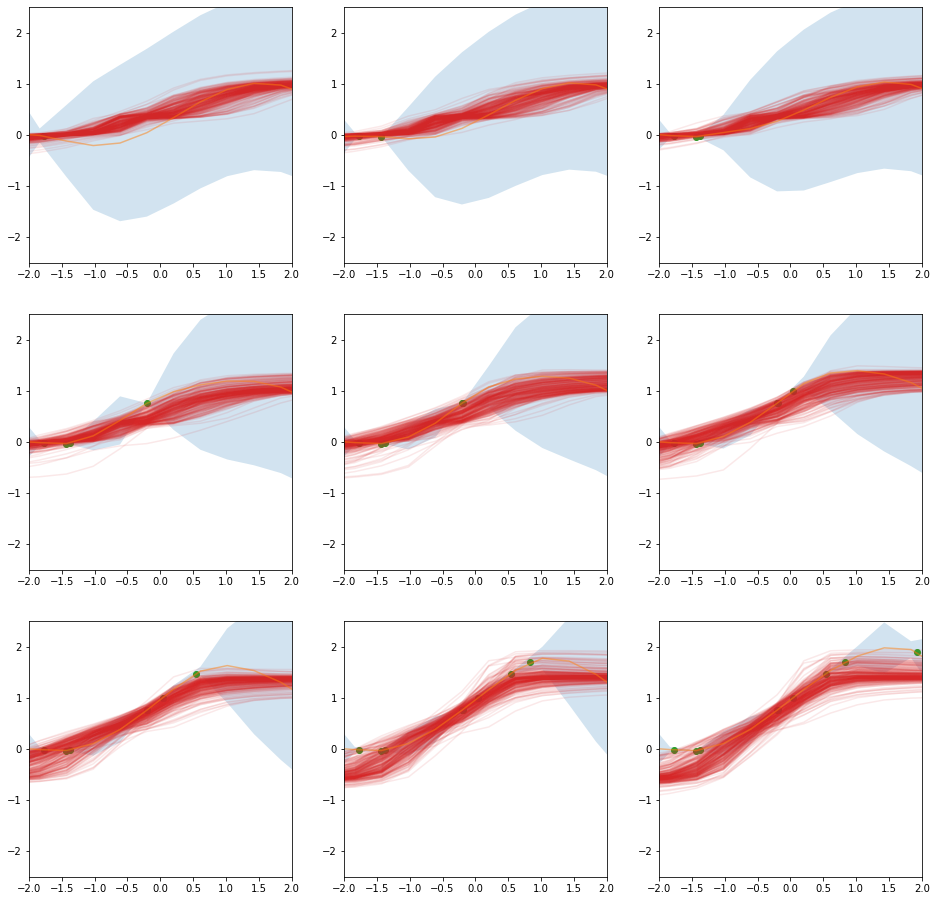

In [600]:
def plot_prediction(ax, context_xs, context_ys, func, kernel):
    input_xs= np.linspace(-10, 10, 50)
    pred_ys, z_mu, z_sigma = neurproc(
        [context_xs.reshape((-1,1)).astype(np.float32)],
        [context_ys.reshape((-1,1)).astype(np.float32)],
        [input_xs.reshape((-1,1)).astype(np.float32)],
        n_draws=250
    )
    pred_ys = tf.squeeze(pred_ys).numpy()

    mean = update_mean(input_xs.reshape(-1,1), context_xs.reshape(-1,1), context_ys.reshape(-1,1), func, kernel)
    std = np.sqrt(update_k(input_xs.reshape(-1,1), context_xs.reshape(-1,1), kernel))
    func_2 = lambda x: update_mean(input_xs.reshape(-1, 1), context_xs.reshape(-1, 1), context_ys.reshape(-1, 1), func, kernel)
    
    for i in range(pred_ys.shape[0]):
        ax.plot(input_xs, pred_ys[i], c=ccycle[3], alpha=0.1)
        #ax.plot(input_xs, draw_gp_post(input_xs.reshape(-1, 1), context_xs.reshape(-1, 1), func_2, kernel), "b", alpha = 0.1)
    ax.plot(input_xs, mean, c=ccycle[1], alpha=.5)
    ax.fill_between(input_xs.reshape(-1), mean - 1.96*std, mean + 1.96*std, "r", label = "_nolegend_", alpha = 0.2)
    ax.scatter(context_xs, context_ys, c=ccycle[2])
    ax.set_xlim((-2, 2))
    ax.set_ylim((-2.5, 2.5))
    ax.vlines(-3, -1.5, 1.5, alpha=.2)
    ax.vlines(3, -1.5, 1.5, alpha=.2)

max_n_context = 9
fig, axes = plt.subplots(3, 3, figsize=(16,16))
all_context_xs = np.sort(np.random.uniform(-2, 2, max_n_context))
all_context_ys = draw_gp_path(all_context_xs, func, kernel).reshape(-1).astype(np.float32)

for i in range(9):
    n_context = i + 1
    context_xs = all_context_xs[:n_context]
    context_ys = all_context_ys[:n_context]
    ax = axes[i // 3, i % 3]
    plot_prediction(ax, context_xs, context_ys, func, kernel)